# TD RL with PPO for Rotation Minimization (Kornia)

This notebook builds a small temporal-difference (TD) reinforcement learning setup using PPO to predict the rotation (in degrees) we should apply each step to minimize the error between a current image and a target image.

Key idea: the environment returns a reward based on **error reduction** (previous MSE minus new MSE), so the policy learns to choose rotation deltas that consistently reduce error. We use `kornia.geometry.transform.rotate` for the actual rotation update.


In [1]:
%cd /Users/masha/Documents/visual-reasoning

import math
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import kornia.geometry.transform as K
import matplotlib.pyplot as plt

# Reproducibility
seed = 7
random.seed(seed)
torch.manual_seed(seed)


/Users/masha/Documents/visual-reasoning


## Build a simple target image

We use a synthetic cross shape so rotations are visually obvious.


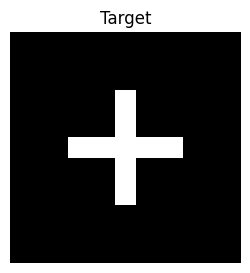

In [2]:
def make_target(size=64, thickness=3):
    img = torch.zeros(1, 1, size, size)
    c = size // 2
    t = thickness
    img[:, :, c - t:c + t, size // 4:3 * size // 4] = 1.0
    img[:, :, size // 4:3 * size // 4, c - t:c + t] = 1.0
    return img

TARGET = make_target(size=64, thickness=3)

plt.figure(figsize=(3, 3))
plt.imshow(TARGET[0, 0].numpy(), cmap="gray")
plt.title("Target")
plt.axis("off")
plt.show()


## Rotation Environment

- State: a 2-channel tensor `[current, target]`.
- Action: a rotation delta (degrees) that we apply to the current image using Kornia.
- Reward: `prev_error - new_error` (TD-friendly and encourages reducing error each step).


In [3]:
@dataclass
class RotationEnvConfig:
    max_steps: int = 12
    max_abs_angle: float = 60.0
    action_scale: float = 8.0  # max absolute delta degrees per step
    done_threshold: float = 1e-4


class RotationEnv:
    def __init__(self, target, cfg: RotationEnvConfig):
        self.target = target
        self.cfg = cfg
        self.device = target.device
        self.reset()

    def _mse(self, a, b):
        return F.mse_loss(a, b)

    def _obs(self):
        # Stack current and target into 2 channels
        return torch.cat([self.current, self.target], dim=1)

    def reset(self):
        self.steps = 0
        # Random initial rotation
        self.current_angle = random.uniform(-self.cfg.max_abs_angle, self.cfg.max_abs_angle)
        with torch.no_grad():
            angle = torch.tensor([self.current_angle], device=self.device)
            self.current = K.rotate(self.target, angle)
            self.prev_error = self._mse(self.current, self.target).item()
        return self._obs().detach()

    def step(self, action_deg):
        # Clamp the action to avoid extreme jumps
        action_deg = float(max(-self.cfg.action_scale, min(self.cfg.action_scale, action_deg)))
        self.current_angle += action_deg
        self.steps += 1

        with torch.no_grad():
            angle = torch.tensor([action_deg], device=self.device)
            self.current = K.rotate(self.current, angle)
            error = self._mse(self.current, self.target).item()

        reward = self.prev_error - error
        self.prev_error = error

        done = (self.steps >= self.cfg.max_steps) or (error <= self.cfg.done_threshold)
        info = {"error": error, "current_angle": self.current_angle}
        return self._obs().detach(), reward, done, info


## PPO Agent

We use a small CNN encoder for the 2-channel observation, followed by:
- Policy head: predicts a mean rotation delta.
- Value head: predicts state value for TD updates.

We apply a tanh-squash to keep actions in a known range.


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, obs_shape):
        super().__init__()
        c, h, w = obs_shape
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        with torch.no_grad():
            n = self.encoder(torch.zeros(1, c, h, w)).view(1, -1).shape[1]
        self.policy = nn.Sequential(
            nn.Linear(n, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
        self.value = nn.Sequential(
            nn.Linear(n, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
        self.log_std = nn.Parameter(torch.tensor([-0.5]))

    def forward(self, obs):
        feat = self.encoder(obs).view(obs.size(0), -1)
        mean = self.policy(feat)
        value = self.value(feat)
        std = self.log_std.exp().expand_as(mean)
        return mean, std, value


def sample_action(model, obs, action_scale):
    mean, std, value = model(obs)
    dist = Normal(mean, std)
    raw_action = dist.rsample()
    action = torch.tanh(raw_action) * action_scale

    # Change-of-variables for tanh-squashed Gaussian
    log_prob = dist.log_prob(raw_action)
    log_prob -= math.log(action_scale)  # scale
    log_prob -= torch.log(1 - torch.tanh(raw_action) ** 2 + 1e-6)
    log_prob = log_prob.sum(-1)

    return action, raw_action, log_prob, value


## PPO Training Loop

We collect rollouts, compute GAE advantages, and update the policy/value with clipped PPO.


In [28]:
# Hyperparameters
cfg = RotationEnvConfig()
steps_per_rollout = 128
ppo_epochs = 100
mini_batch_size = 32
clip_eps = 0.2
gamma = 0.99
lam = 0.95
value_coef = 0.5
entropy_coef = 0.01
lr = 3e-4

# Setup
env = RotationEnv(TARGET, cfg)
obs_shape = env.reset().shape[1:]
model = ActorCritic(obs_shape)
optimizer = optim.Adam(model.parameters(), lr=lr)

def compute_gae(rewards, values, dones, next_value):
    advantages = torch.zeros_like(rewards)
    gae = 0.0
    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * mask - values[t]
        gae = delta + gamma * lam * mask * gae
        advantages[t] = gae
        next_value = values[t]
    returns = advantages + values
    return advantages, returns

# Training
all_returns = []
obs = env.reset()

for update in range(30):
    obs_buf = []
    raw_action_buf = []
    action_buf = []
    logp_buf = []
    reward_buf = []
    done_buf = []
    value_buf = []

    for step in range(steps_per_rollout):
        action, raw_action, logp, value = sample_action(model, obs, cfg.action_scale)
        next_obs, reward, done, info = env.step(action.item())

        obs_buf.append(obs)
        # Detach rollout tensors to avoid backprop through old graphs
        raw_action_buf.append(raw_action.detach())
        action_buf.append(action)
        logp_buf.append(logp.detach())
        reward_buf.append(torch.tensor(reward, dtype=torch.float32))
        done_buf.append(torch.tensor(float(done)))
        value_buf.append(value.squeeze(0).detach())

        obs = next_obs
        if done:
            all_returns.append(-info["error"])  # for quick monitoring
            obs = env.reset()

    # Bootstrap
    with torch.no_grad():
        _, _, next_value = model(obs)

    rewards = torch.stack(reward_buf)
    values = torch.stack(value_buf).squeeze(-1)
    dones = torch.stack(done_buf)
    advantages, returns = compute_gae(rewards, values, dones, next_value.item())
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Flatten buffers
    obs_batch = torch.cat(obs_buf, dim=0)
    raw_action_batch = torch.cat(raw_action_buf, dim=0)
    old_logp_batch = torch.cat(logp_buf, dim=0).detach()
    returns_batch = returns.detach()
    adv_batch = advantages.detach()

    # PPO update
    idxs = torch.randperm(steps_per_rollout)
    for _ in range(ppo_epochs):
        for start in range(0, steps_per_rollout, mini_batch_size):
            mb_idx = idxs[start:start + mini_batch_size]
            mb_obs = obs_batch[mb_idx]
            mb_raw_action = raw_action_batch[mb_idx]
            mb_old_logp = old_logp_batch[mb_idx]
            mb_returns = returns_batch[mb_idx]
            mb_adv = adv_batch[mb_idx]

            mean, std, value = model(mb_obs)
            dist = Normal(mean, std)

            logp = dist.log_prob(mb_raw_action)
            logp -= math.log(cfg.action_scale)
            logp -= torch.log(1 - torch.tanh(mb_raw_action) ** 2 + 1e-6)
            logp = logp.sum(-1)

            ratio = torch.exp(logp - mb_old_logp)
            surr1 = ratio * mb_adv
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * mb_adv
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(value.squeeze(-1), mb_returns)
            entropy = dist.entropy().mean()

            loss = policy_loss + value_coef * value_loss - entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if (update + 1) % 5 == 0:
        print(f"Update {update+1:02d} | recent returns: {all_returns[-5:]}")



Update 05 | recent returns: [-0.01049809530377388, -0.008701831102371216, -0.011505115777254105, -0.010107853449881077, -0.010130664333701134]
Update 10 | recent returns: [-0.02459416352212429, -0.011211390607059002, -0.045901451259851456, -0.03191792219877243, -0.03725403919816017]
Update 15 | recent returns: [-0.010437018238008022, -0.009425291791558266, -0.029152289032936096, -0.008955927565693855, -0.011881938204169273]
Update 20 | recent returns: [-0.009928347542881966, -0.010069569572806358, -0.010213209316134453, -0.009832898154854774, -0.00971977412700653]
Update 25 | recent returns: [-0.007598312571644783, -0.00944999884814024, -0.009735560044646263, -0.009885911829769611, -0.014359722845256329]
Update 30 | recent returns: [-0.006884383503347635, -0.010705719701945782, -0.007342974189668894, -0.03889923542737961, -0.010486934334039688]


## Quick training curve


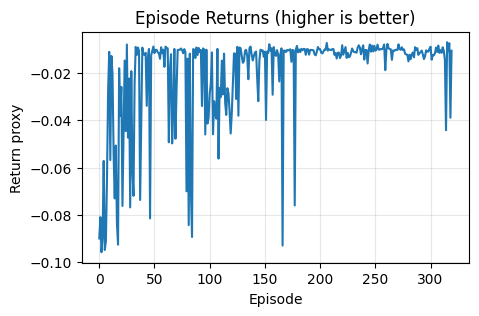

In [29]:
plt.figure(figsize=(5, 3))
plt.plot(all_returns)
plt.title("Episode Returns (higher is better)")
plt.xlabel("Episode")
plt.ylabel("Return proxy")
plt.grid(True, alpha=0.3)
plt.show()


## Evaluate a single rollout with reasoning

We print step-by-step: the action (rotation delta), error before and after. This shows the *reasoning signal* the policy is optimizing: it is rewarded for reducing error each step.


Initial angle: 27.85 deg, error: 0.099945
Step 00 | action -6.519 deg | error 0.099945 -> 0.077091 | reward +0.022854
Step 01 | action +3.943 deg | error 0.077091 -> 0.086833 | reward -0.009742
Step 02 | action -5.015 deg | error 0.086833 -> 0.068403 | reward +0.018430
Step 03 | action +0.309 deg | error 0.068403 -> 0.069040 | reward -0.000637
Step 04 | action +0.300 deg | error 0.069040 -> 0.069648 | reward -0.000608
Step 05 | action -3.104 deg | error 0.069648 -> 0.056718 | reward +0.012931
Step 06 | action -0.450 deg | error 0.056718 -> 0.054683 | reward +0.002035
Step 07 | action -0.690 deg | error 0.054683 -> 0.051639 | reward +0.003045
Step 08 | action -1.785 deg | error 0.051639 -> 0.044281 | reward +0.007357
Step 09 | action -2.376 deg | error 0.044281 -> 0.035240 | reward +0.009041
Step 10 | action -3.475 deg | error 0.035240 -> 0.023851 | reward +0.011389
Step 11 | action -4.647 deg | error 0.023851 -> 0.012941 | reward +0.010910


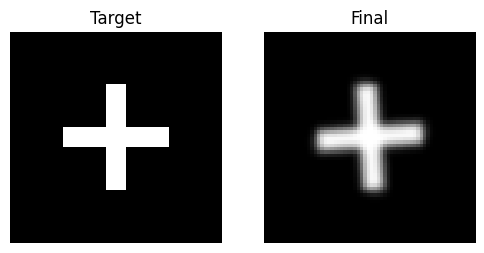

In [46]:
obs = env.reset()
print(f"Initial angle: {env.current_angle:.2f} deg, error: {env.prev_error:.6f}")

history = []
for t in range(cfg.max_steps):
    with torch.no_grad():
        action, raw_action, logp, value = sample_action(model, obs, cfg.action_scale)

    error_before = env.prev_error
    next_obs, reward, done, info = env.step(action.item())
    error_after = info["error"]

    history.append((t, action.item(), error_before, error_after, reward))
    print(
        f"Step {t:02d} | action {action.item():+6.3f} deg | "
        f"error {error_before:.6f} -> {error_after:.6f} | reward {reward:+.6f}"
    )

    obs = next_obs
    if done:
        break

# Visualize target vs final
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(env.target[0, 0].numpy(), cmap="gray")
plt.title("Target")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(env.current[0, 0].numpy(), cmap="gray")
plt.title("Final")
plt.axis("off")
plt.show()


## Notes

- This is a minimal PPO implementation focused on the rotation task.
- The reward is TD-style (reduction in error), which makes learning stable even with short rollouts.
- For more complex tasks, swap the synthetic target for a real image tensor.
